In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits
import random

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

In [2]:
# select mission, target, and paths

MISSION = "Kepler"
TARGET  = "K00137"
PRIMARY_DIR = '/Users/research/projects/alderaan/'
TRACE_FILE  = '/Users/research/projects/alderaan/__midway_traces/K00137/K00137_sin_ttvs_200624.fits'

# Make sure the necessary paths exist

In [3]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Get sinusoidal TTV model posteriors

In [4]:
# Read in the fits file with saved traces

with pyfits.open(TRACE_FILE) as sin_trace:
    header  = sin_trace[0].header
    hdulist = pyfits.HDUList(sin_trace)
    
    NDRAWS, NPL = sin_trace['RP'].shape
    
    # stellar parameters
    RSTAR  = sin_trace['RSTAR'].data
    MSTAR  = sin_trace['MSTAR'].data
    U      = sin_trace['U'].data
    U1, U2 = U[:,0], U[:,1]
    
    # planetary parameters
    T0   = sin_trace['T0'].data
    P    = sin_trace['P'].data
    LOGR = sin_trace['LOGR'].data
    RP   = sin_trace['RP'].data
    B    = sin_trace['B'].data
    
    # TTV parameters
    C0 = sin_trace['C0'].data
    C1 = sin_trace['C1'].data
    C2 = np.zeros_like(C0)
    C3 = np.zeros_like(C0)
    
    A1 = np.zeros_like(C0)
    B1 = np.zeros_like(C0)
    A2 = np.zeros_like(C0)
    B2 = np.zeros_like(C0)
    AMP = np.zeros_like(C0)
    
    FPLUS  = np.zeros_like(C0)
    FMINUS = np.zeros_like(C0)
    FTTV1  = np.zeros_like(C0)
    FTTV2  = np.zeros_like(C0)
    
    TTS = [None]*NPL
    
    for npl in range(NPL):
        try: C2[:,npl] = sin_trace['C2_{0}'.format(npl)].data
        except: pass
        
        try: C3[:,npl] = sin_trace['C3_{0}'.format(npl)].data
        except: pass
        
        try: A1[:,npl] = sin_trace['A1_{0}'.format(npl)].data
        except: pass
        
        try: B1[:,npl] = sin_trace['B1_{0}'.format(npl)].data
        except: pass
        
        try: A2[:,npl] = sin_trace['A2_{0}'.format(npl)].data
        except: pass
        
        try: B2[:,npl] = sin_trace['B2_{0}'.format(npl)].data
        except: pass
        
        try: AMP[:,npl] = sin_trace['amp_{0}'.format(npl)].data
        except: pass
        
        try: FPLUS[:,npl] = sin_trace['FPLUS_{0}'.format(npl)].data
        except: pass
        
        try: FMINUS[:,npl] = sin_trace['FMINUS_{0}'.format(npl)].data
        except: pass
        
        try: FTTV1[:,npl] = sin_trace['FTTV1_{0}'.format(npl)].data
        except: pass
        
        try: FTTV2[:,npl] = sin_trace['FTTV2_{0}'.format(npl)].data
        except: pass       
        
        try: TTS[npl] = sin_trace['TTS_{0}'.format(npl)].data
        except: pass

In [5]:
with pyfits.open(TRACE_FILE) as sin_trace:
    header  = sin_trace[0].header
    hdulist = pyfits.HDUList(sin_trace)
    
    NDRAWS, NPL = sin_trace['RP'].shape
    
    # GP parameters
    LOGSW4 = np.zeros((NDRAWS,4))
    LOGW0  = np.zeros((NDRAWS,4))
    LOGQ   = np.zeros((NDRAWS,4))
    
    for z in range(4):
        try: LOGSW4[:,z] = sin_trace['LOGSW4_{0}'.format(z)].data
        except: pass
        
        try: LOGW0[:,z] = sin_trace['LOGW0_{0}'.format(z)].data
        except: pass
        
        try: LOGQ[:,z] = sin_trace['LOGQ_{0}'.format(z)].data
        except: pass

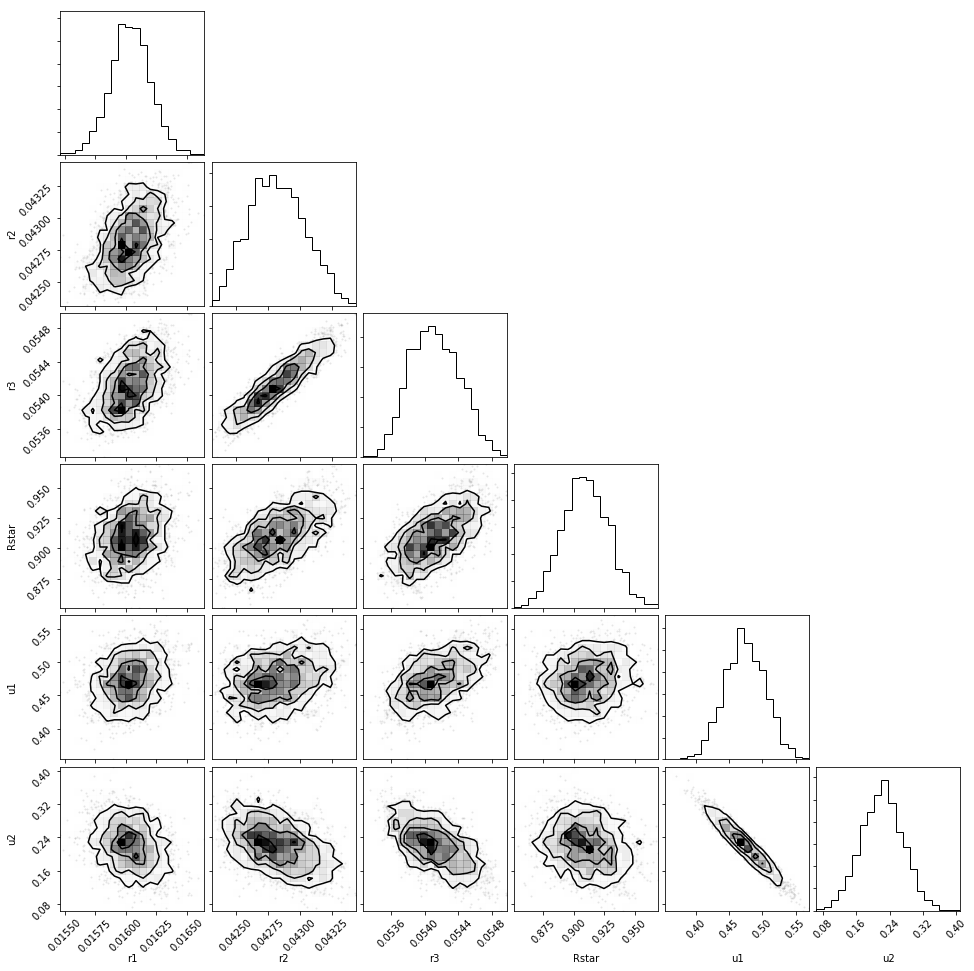

In [6]:
data = np.stack([RP[:,0]/RSTAR, RP[:,1]/RSTAR, RP[:,2]/RSTAR, RSTAR, U1, U2]).swapaxes(0,1)
labels = ["r1", "r2", "r3", "Rstar", "u1", "u2"]

fig = corner.corner(data, labels=labels)

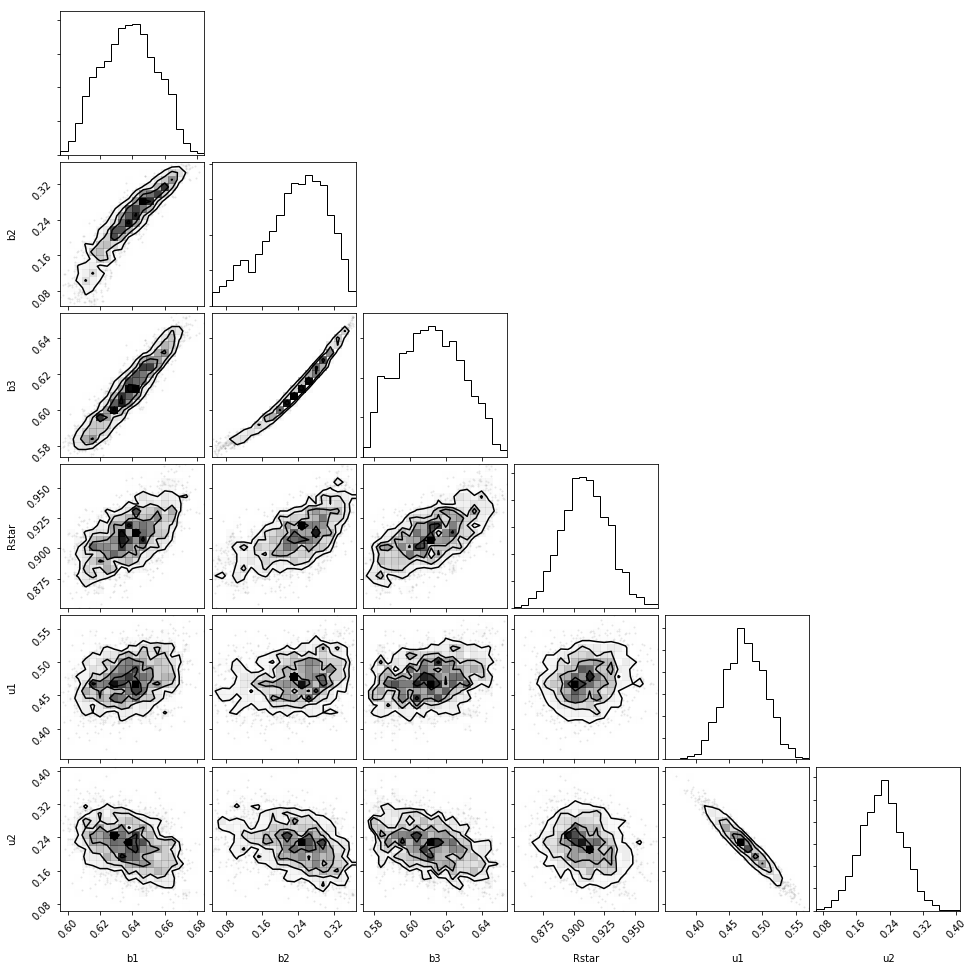

In [7]:
data = np.stack([B[:,0], B[:,1], B[:,2], RSTAR, U1, U2]).swapaxes(0,1)
labels = ["b1", "b2", "b3", "Rstar", "u1", "u2"]

fig = corner.corner(data, labels=labels)

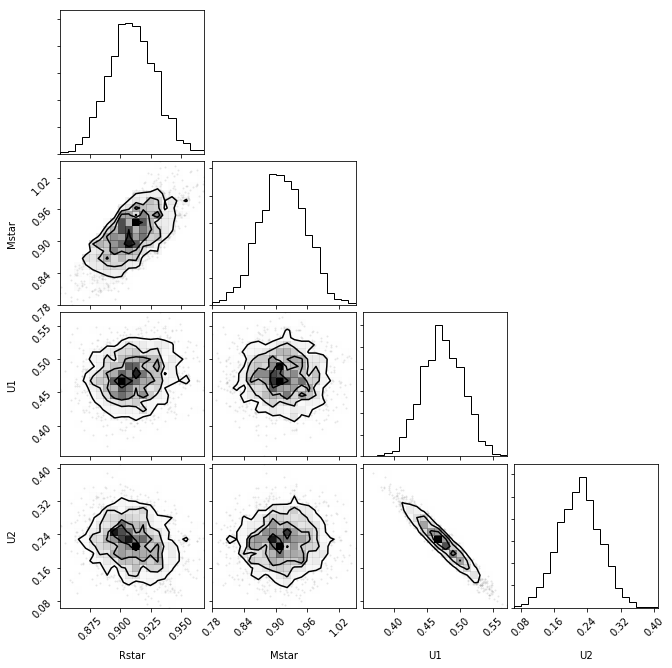

In [8]:
data = np.stack([RSTAR, MSTAR, U1, U2]).swapaxes(0,1)
labels = ['Rstar', 'Mstar', 'U1', 'U2']

fig = corner.corner(data, labels=labels)

In [9]:
from KDEpy import FFTKDE

plt.style.use(["dark_background"])

SMALL_SIZE = 16
MEDIUM_SIZE = 20
LARGE_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, frameon=False)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

plt.rc('axes', linewidth=2)

colors = ['cornflowerblue', 'orange', 'indianred']

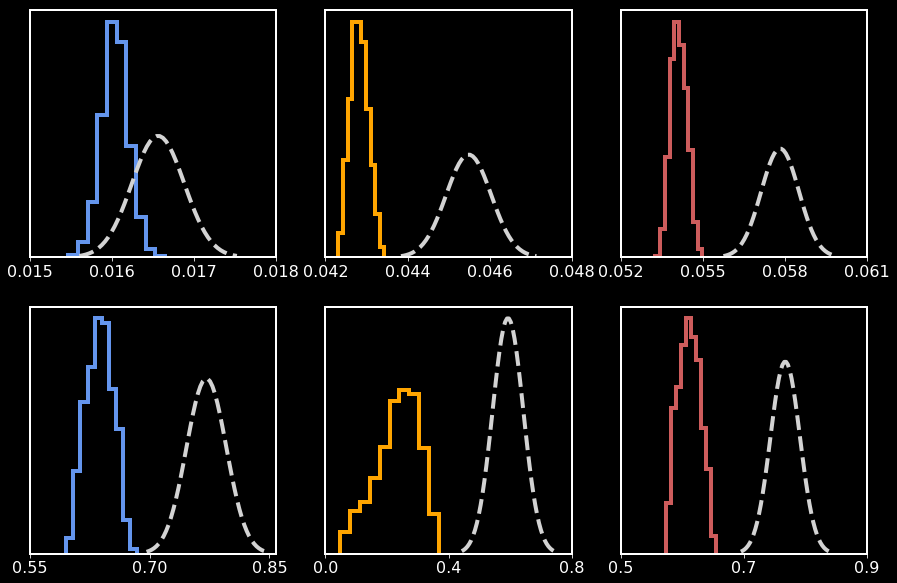

In [18]:
cochran_rprs = np.array([[0.01656, 0.04549, 0.05782], [0.00032, 0.00055, 0.00069]])
cochran_b = np.array([[0.771, 0.593, 0.767],[0.025, 0.050, 0.024]])


rticks = [(0.015,0.016,0.017,0.018), (0.042, 0.044, 0.046, 0.048), (0.052, 0.055, 0.058, 0.061)]
bticks = [(0.55, 0.7, 0.85), (0.0, 0.4, 0.8), (0.5, 0.7, 0.9)]


fig, axes = plt.subplots(2,3, figsize=(15,10))

for npl in range(NPL):
    
    # first plot cochran
    r = cochran_rprs[:,npl]
    b = cochran_b[:,npl]
    
    xr = np.linspace(-3*r[1],3*r[1])
    yr = stats.norm.pdf(xr, scale=r[1])

    xb = np.linspace(-3*b[1],3*b[1])
    yb = stats.norm.pdf(xb, scale=b[1])
    
    axes[0,npl].plot(xr + r[0], yr, c='lightgrey', lw=4, ls='--')
    axes[1,npl].plot(xb + b[0], yb, c='lightgrey', lw=4, ls='--')
    
    
    # then plot my results
    #r = RP[:,npl]/RSTAR
    #b = B[:,npl]
    
    #xr = np.linspace(r.min()*0.99,r.max()*1.01, len(r))
    #yr = FFTKDE(kernel='gaussian', bw='silverman').fit(r).evaluate(xr)
    
    #xb = np.linspace(b.min()*0.99,b.max()*1.01, len(b))
    #yb = FFTKDE(kernel='gaussian', bw='silverman').fit(b).evaluate(xb)
    
    #axes[0].plot(xr, yr, color=colors[npl], lw=4)
    #axes[1].plot(xb, yb, color=colors[npl], lw=4)
    
    axes[0,npl].hist(RP[:,npl]/RSTAR, color=colors[npl], histtype="step", lw=4, density=True)
    axes[1,npl].hist(B[:,npl], color=colors[npl], histtype="step", lw=4, density=True)
        
    axes[0,npl].set_xticks(rticks[npl])
    axes[0,npl].set_yticks([])
    axes[1,npl].set_xticks(bticks[npl])
    axes[1,npl].set_yticks([])

    
plt.savefig("/Users/research/Desktop/posteriors_vs_cochran.pdf", bbox_inches="tight", transparent=True)
plt.show()

In [49]:
axes.shape

(3, 2)

In [ ]:
for npl in range(NPL):
    data = np.stack([T0[:,npl], P[:,npl], RP[:,npl], B[:,npl]]).swapaxes(0,1)
    labels = ['$T_0$', 'P', '$r_p$', 'b']

    fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))

In [ ]:
for npl in range(NPL):
    data = np.stack([C0[:,npl], C1[:,npl], C2[:,npl], C3[:,npl]]).swapaxes(0,1)
    labels = ['C0', 'C1', 'C2', 'C3']

    fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))

In [ ]:
for npl in range(NPL):
    try:
        data = np.stack([A1[:,npl], B1[:,npl], A2[:,npl], B2[:,npl], \
                        FTTV1[:,npl], FTTV2[:,npl]]).swapaxes(0,1)
        labels = ['A1', 'B1', 'A2', 'B2', '$fttv_1$', '$fttv_2$']
        fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        
    except:
        try:
            data = np.stack([A1[:,npl], B1[:,npl], FTTV1[:,npl]]).swapaxes(0,1)
            labels = ['A1', 'B1', '$fttv_1$']
            fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        except:
            pass


In [ ]:
for z in range(4):
    data  = []
    labels = []

    if np.sum(LOGSW4[:,z] != 0):
        data.append(LOGSW4[:,z])
        labels.append('LogSw4')
        
    if np.sum(LOGW0[:,z] != 0):
        data.append(LOGW0[:,z])
        labels.append('Logw0')    
    
    if np.sum(LOGQ[:,z] != 0):
        data.append(LOGQ[:,z])
        labels.append('LogQ')
        
    
    try:
        data = np.stack(data).swapaxes(0,1)
        fig = corner.corner(data, labels=labels)
        
    except:
        pass

# Get transit times, linear ephemeris and O-C

In [ ]:
epochs = np.zeros(NPL)
periods = np.zeros(NPL)

sin_transit_times = []
sin_ephemeris = []
transit_inds = []

for npl in range(NPL):   
    sin_transit_times.append(np.median(TTS[npl], axis=0))
    
    t0  = np.median(T0[:,npl])
    per = np.median(P[:,npl])
    tts = sin_transit_times[npl]
    
    tinds = np.array(np.floor((tts - t0 + per/2) / per), dtype='int')
    
    epochs[npl] = t0
    periods[npl] = per
    sin_ephemeris.append(t0 + per*tinds)
    transit_inds.append(tinds)

In [ ]:
draws = random.sample(range(NDRAWS), 50)

fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    for d in draws:
        xtime = TTS[npl][d]
        yomc  = (xtime - (T0[d,npl] + P[d,npl]*transit_inds[npl]))*24*60

        axes[npl].plot(xtime, yomc, alpha=0.1, color='C{0}'.format(npl))    
    
    xtime = sin_transit_times[npl]
    yomc  = (sin_transit_times[npl]-sin_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
    
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)    
plt.show()

# Read in detrended lightcurves and independent TTV estimates

In [ ]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

In [ ]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
transit_inds = []
indep_transit_times = []
indep_ephemeris = []


for npl in range(NPL):
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_indep_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    indep_transit_times.append(data_in[:,1])
    
    pfit = np.polyfit(transit_inds[npl], indep_transit_times[npl], 1)
    
    indep_ephemeris.append(np.polyval(pfit, transit_inds[npl]))
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [ ]:
# get estimate of ttv amplitdue and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - sin_transit_times[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl]

# Set up GP

In [ ]:
# Read in noise model GP priors
gp_percs = []

for z in range(4):
    fname_in = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)
    
    with open(fname_in) as infile:
        gp_percs.append(json.load(infile))


# Read in quarter-by-quarter variances
var_by_quarter = np.genfromtxt(NOISE_DIR + TARGET + '_var_by_quarter.txt')[:,1]

In [ ]:
# this uses the original priors for the transit shape model
gp_priors = []

for z in range(4):
    gpi = {}
    
    for k in gp_percs[z].keys():
        
        perc = np.array(gp_percs[z]['percentiles'])
        
        med = np.array(gp_percs[z][k])[perc == 50.0][0]
        err1 = np.array(gp_percs[z][k])[perc == 84.1][0]
        err2 = np.array(gp_percs[z][k])[perc == 15.9][0]
        
        dev = np.sqrt((err1-med)**2/2 + (err2-med)**2/2)
        
        gpi[k] = (med, dev)
        
    gp_priors.append(gpi)

In [ ]:
# this uses the posteriors of the transit shape model as the priors on the timing model
gp_priors = []

for z in range(4):
    gpi = {}
    
    gpi['logw0'] = (np.median(LOGW0[:,z]), np.std(LOGW0[:,z]))
    gpi['logSw4'] = (np.median(LOGSW4[:,z]), np.std(LOGSW4[:,z]))
    gpi['logQ'] = (np.median(LOGQ[:,z]), np.std(LOGQ[:,z]))
        
    gp_priors.append(gpi)

# Grab the relevant data

In [ ]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_error = []
all_dtype = []

lc_flux = []
sc_flux = []

if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_error.append(sc.error[use])
                all_dtype.append('short')

                sc_flux.append(sc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)

lc_quarters = np.arange(18)[np.array(all_dtype) == 'long']
sc_quarters = np.arange(18)[np.array(all_dtype) == 'short']


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Set fixed values for star and planet parameters

In [ ]:
u = np.median(U1), np.median(U2)

Rstar = np.median(RSTAR)
Mstar = np.median(MSTAR)

rp = np.median(RP,0)
b  = np.median(B,0)

# for now hard-coding in Kepler-18 durations
DURS = np.array([0.14209083, 0.14688333, 0.08254583])

# Identify overlapping transits

In [ ]:
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(sin_transit_times[i]), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for tt in sin_transit_times[j]:
                overlap[i] += np.abs(sin_transit_times[i] - tt) < dur_max

In [ ]:
thresh = np.zeros(19)
thresh[0] = np.min(np.hstack([lc.time, sc.time]))

for q in range(18):
    thresh[q+1] = np.max(np.hstack([lc.time[lc.quarter==q],sc.time[sc.quarter==q]]))
    
transit_quarter = [None]*NPL

for npl in range(NPL):
    stt = sin_transit_times[npl]
    transit_quarter[npl] = np.zeros(len(stt), dtype='int')

    for q in range(18): 
        transit_quarter[npl][(stt > thresh[q])*(stt<thresh[q+1])] = q
        
plt.figure(figsize=(20,4))
plt.plot(np.hstack([lc.time,sc.time]), np.hstack([lc.flux,sc.flux]), 'k')
for th in thresh:
    plt.axvline(th, color='r')
plt.show()

# Fit a single planet w/ no noise

In [ ]:
rough_bf = [3.65, 2.79, 2.43]
rough_bf = [1.0, 1.0, 1.0]

In [ ]:
tts_chains = []
offset_chains = []
pop_sd_chains = []

FITTHIS = [1,2]

for npl in FITTHIS:
    for z in range(4):
        tqz = transit_quarter[npl]
        tqz = np.unique(tqz[tqz%4 == z])

        
        # grab transit times
        fixed_tts = sin_transit_times[npl]
        
        use_lc = (~overlap[npl])*(transit_quarter[npl] % 4 == z)*np.isin(transit_quarter[npl], lc_quarters)
        use_sc = (~overlap[npl])*(transit_quarter[npl] % 4 == z)*np.isin(transit_quarter[npl], sc_quarters)
        use = use_lc + use_sc
        
        # set up scaling factor due to binning uncertainty for short vs long cadence
        bin_factor = np.zeros(len(use))
        bin_factor[use_lc] = rough_bf[npl]
        bin_factor[use_sc] = 1.0
        bin_factor = bin_factor[use]
        

        # now build the model
        with pm.Model() as hbm_model:
            flux0 = 1.0

            log_pop_var = pm.Normal('log_pop_var', mu=2*np.log(ttv_amps[npl]), sd=np.log(4.5))
            pop_sd = pm.Deterministic('pop_sd', T.exp(0.5*log_pop_var))
            
            pop_sd = 10*ttv_amps[npl]

            
            # transit times
            #tt_offset = pm.StudentT('tt_offset', nu=2, shape=len(fixed_tts[use]))
            tt_offset = pm.Normal('tt_offset', mu=0, sd=1, shape=len(fixed_tts[use]))
            transit_times = pm.Deterministic('tts', fixed_tts[use] + tt_offset*pop_sd*bin_factor)


            # set up stellar model and planetary orbit
            exoSLC = exo.StarryLightCurve(u)
            orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[transit_inds[npl][use]], 
                                         b=b[npl], r_star=Rstar, m_star=Mstar)
            
            
            # now evaluate the model for each quarter
            light_curves       = [None]*len(tqz)
            summed_light_curve = [None]*len(tqz)
            model_flux         = [None]*len(tqz)

            obs = [None]*len(tqz)

            for j, q in enumerate(tqz):
                # set oversampling factor
                if all_dtype[q] == 'short':
                    oversample = 1
                    
                    muse = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)
                    m = (sc.mask[npl,muse] == 1)*(np.array(sc.mask[:,muse], dtype='int').sum(0) == 1)

                elif all_dtype[q] == 'long':
                    oversample = 15
                    
                    muse = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
                    m = (lc.mask[npl,muse] == 1)*(np.array(lc.mask[:,muse], dtype='int').sum(0) == 1)
                    
                # calculate light curves
                light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=all_time[q][m], oversample=oversample)
                summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q][m]))
                model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])

                # here's the likelihood function by season
                obs[j] = pm.Normal("obs_{0}".format(j), \
                                   mu = model_flux[j], \
                                   sd = all_error[q][m],
                                   observed = all_flux[q][m])
            

        with hbm_model:
            hbm_trace = pm.sample(tune=2000, draws=1000, start=hbm_model.test_point, chains=2,
                                  step=exo.get_dense_nuts_step(target_accept=0.9))
        
        tts_chains.append(np.copy(np.array(hbm_trace['tts'])))
        offset_chains.append(np.copy(np.array(hbm_trace['tt_offset'])))
        #pop_sd_chains.append(np.copy(np.array(hbm_trace['pop_sd'])))

In [ ]:
# make primary HDU
primary_hdu = pyfits.PrimaryHDU()
header = primary_hdu.header
header['TARGET'] = TARGET
primary_hdu.header = header
    
# add it to HDU list
hbm_hdulist = []
hbm_hdulist.append(primary_hdu)
    
# grab all samples from trace
for i, npl in enumerate(FITTHIS):
    combo_tts = []
    combo_offset = []
    #combo_pop_sd = []
    
    for z in range(4):
        combo_tts.append(tts_chains[4*i+z])
        combo_offset.append(offset_chains[4*i+z])
        #combo_pop_sd.append(pop_sd_chains[4*npl+z])
        
    combo_tts = np.hstack(combo_tts)
    combo_offset = np.hstack(combo_offset)
    #combo_pop_sd = np.vstack(combo_pop_sd).swapaxes(0,1)

    order = np.argsort(np.median(combo_tts,0))

    combo_tts = combo_tts[:,order]
    combo_offset = combo_offset[:,order]

    # add to HDUList
    hbm_hdulist.append(pyfits.ImageHDU(combo_tts, name='TTS_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_offset, name='OFFSET_{0}'.format(npl)))
    #hbm_hdulist.append(pyfits.ImageHDU(combo_pop_sd, name='POP_SD_{0}'.format(npl)))

    
hbm_hdulist = pyfits.HDUList(hbm_hdulist)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

In [ ]:
len(hbm_hdulist)

In [ ]:
tts = np.hstack(tts_chains)

order = np.argsort(np.median(tts,0))

tts = tts[:,order]

tts_med = np.median(tts,0)
tts_std = np.std(tts,0)

per = np.median(tts_med[1:]-tts_med[:-1])
epoch = tts_med[0]

inds = np.array(np.floor((tts_med - epoch + per/2)/per), dtype='int')

pfit = np.polyfit(inds, tts_med, 1)
ephem = np.polyval(pfit, inds)

xtime = tts_med
yomc  = (tts_med-ephem)*24*60
yerr  = tts_std*24*60

stime = sin_transit_times[npl]
somc  = (sin_transit_times[npl]-sin_ephemeris[npl])*24*60
    

plt.figure(figsize=(20,4))
plt.errorbar(xtime, yomc, yerr=yerr, fmt='o', color='C{0}'.format(npl))
plt.plot(stime, somc, color='grey', zorder=0)
plt.show()


In [ ]:
for npl in FITTHIS:
    fig, axes = plt.subplots(2,1, figsize=(20,8))
    
    for z in range(4):
        hbm_trace = hbm_traces[npl][z]
        use = (~overlap[npl])*(transit_quarter[npl] % 4 == z)    

        tts_offs = np.array(hbm_trace['tt_offset_p{0}_s{1}'.format(npl,z)])

        tts_med = np.median(hbm_trace['tts_p{0}_s{1}'.format(npl,z)], 0)
        tts_err = np.std(hbm_trace['tts_p{0}_s{1}'.format(npl,z)], 0)

        tts_84 = np.percentile(hbm_trace['tts_p{0}_s{1}'.format(npl,z)], 84.1, 0)
        tts_16 = np.percentile(hbm_trace['tts_p{0}_s{1}'.format(npl,z)], 15.9, 0)
        tts_err = (tts_84-tts_16)/2

        xtime = sin_transit_times[npl][use]
        yomc  = (tts_med-sin_ephemeris[npl][use])*24*60
        yerr  = tts_err*24*60

        somc = (sin_transit_times[npl][use]-sin_ephemeris[npl][use])*24*60

        axes[0].errorbar(xtime, yomc, yerr=yerr, fmt='.', c='C{0}'.format(npl))
        axes[1].errorbar(xtime, yomc-somc, yerr=yerr, fmt='.', c='C{0}'.format(npl))

In [ ]:
for npl in FITTHIS:
    for z in range(4):
        hbm_trace = hbm_traces[npl][z]

        fig, axes = plt.subplots(1,3, figsize=(24,5))

        axes[0].hist(hbm_trace['tt_offset_p{0}_s{1}'.format(npl,z)].reshape(-1), color='C{0}'.format(npl), bins=np.linspace(-7,8,30))
        axes[0].set_title('tt_offset', fontsize=24)

        axes[1].hist(hbm_trace['log_pop_var_p{0}_s{1}'.format(npl,z)], color='C{0}'.format(npl))
        axes[1].set_title('log_pop_var', fontsize=24)

        axes[2].hist(hbm_trace['pop_sd_p{0}_s{1}'.format(npl,z)]*24*60, color='C{0}'.format(npl))
        axes[2].set_title('pop_sd', fontsize=24)

        plt.show()

# (4) Fit a Hierarchical Bayesian Model (HBM) for TTVs

In [ ]:
print('\n(4) Fitting HIERARCHICAL TTV model')

In [ ]:
with pm.Model() as hbm_model:
    # hierarchical populatio nparameters
    log_pop_var = pm.Normal('log_pop_var', mu=2*np.log(ttv_amps), sd=np.log(4.5)*np.ones(NPL), shape=NPL)
    pop_sd = pm.Deterministic('pop_sd', T.exp(0.5*log_pop_var))

    # transit times
    tt_offset = []
    transit_times = []

    for npl in range(NPL):
        tt_offset.append(pm.StudentT('tt_offset_{0}'.format(npl), nu=2, shape=len(sin_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              sin_transit_times[npl] + tt_offset[npl]*pop_sd[npl]))

    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
            
        
    # nuissance parameters (one mean flux; variance by quarter)
    flux0 = pm.Normal('flux0', mu=np.ones(nq), sd=np.sqrt(var_by_quarter)/4, shape=nq)
    logvar = pm.Normal('logvar', mu=np.log(var_by_quarter), sd=np.log(4)*np.ones(nq), shape=nq)
   
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    obs = [None]*nq
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the likelihood function by season
        obs[j] = pm.Normal("obs_{0}".format(j), \
                           mu = model_flux[j], \
                           sd = T.sqrt(T.exp(logvar[j])*T.ones(len(all_time[q]))), \
                           observed = all_flux[q])

In [ ]:
with hbm_model:
    hbm_map = exo.optimize(start=hbm_model.test_point)

In [ ]:
hbm_transit_times = []
hbm_ephemeris = []
hbm_err = []

for npl in range(NPL):
    hbm_transit_times.append(hbm_map['tts_{0}'.format(npl)])
    hbm_ephemeris.append(hbm_map['P'][npl]*transit_inds[npl] + hbm_map['T0'][npl])
    
    hbm_err.append(np.ones_like(hbm_ephemeris[npl])*np.std(hbm_transit_times[npl]-sin_transit_times[npl]))

In [ ]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    xtime = hbm_transit_times[npl]
    yomc  = (hbm_transit_times[npl] - hbm_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_hbm.pdf', bbox_inches='tight')
plt.show()

### (4) Sample from posteriors for HBM model

In [ ]:
with hbm_model:
    hbm_trace = pm.sample(tune=3000, draws=1000, start=hbm_model.test_point, chains=2, \
                      step=exo.get_dense_nuts_step(target_accept=0.9))

In [ ]:
# select which variables to save (don't save full GP or model traces or "under the hood" variables)
hbm_map_keys = list(hbm_map.keys())
hbm_varnames = []

for i, hmk in enumerate(hbm_map_keys):
    skip = ("gp_pred" in hmk) + ("model_flux" in hmk) + ("__" in hmk)

    if skip == False:
        hbm_varnames.append(hmk)

In [ ]:
hbm_hdulist = io.trace_to_hdulist(hbm_trace, hbm_varnames, TARGET)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

# Old code - plotting

In [ ]:
tts_offs = np.array(hbm_trace['tt_offset_{0}'.format(npl)])

tts_med = np.median(hbm_trace['tts_{0}'.format(npl)], 0)
tts_err = np.std(hbm_trace['tts_{0}'.format(npl)], 0)

tts_84 = np.percentile(hbm_trace['tts_{0}'.format(npl)], 84.1, 0)
tts_16 = np.percentile(hbm_trace['tts_{0}'.format(npl)], 15.9, 0)
tts_err = (tts_84-tts_16)/2

xtime = sin_transit_times[npl][~overlap[npl]]
yomc  = (tts_med-sin_ephemeris[npl][~overlap[npl]])*24*60
yerr  = tts_err*24*60

somc = (sin_transit_times[npl][~overlap[npl]]-sin_ephemeris[npl][~overlap[npl]])*24*60


plt.figure(figsize=(13,5))
plt.errorbar(xtime, yomc, yerr=yerr, fmt='o', c='C{0}'.format(npl))
plt.show()

plt.figure(figsize=(13,3))
plt.errorbar(xtime, yomc-somc, yerr=yerr, fmt='o', c='C{0}'.format(npl))
plt.show()

plt.figure(figsize=(13,3))
plt.plot(xtime, yerr, c='C{0}'.format(npl))
plt.show()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,5))

axes[0].hist(hbm_trace['tt_offset_{0}'.format(npl)].reshape(-1), color='C{0}'.format(npl), bins=np.linspace(-7,8,30))
axes[0].set_title('tt_offset', fontsize=24)

axes[1].hist(hbm_trace['log_pop_var_{0}'.format(npl)], color='C{0}'.format(npl))
axes[1].set_title('log_pop_var', fontsize=24)

axes[2].hist(hbm_trace['pop_sd_{0}'.format(npl)]*24*60, color='C{0}'.format(npl))
axes[2].set_title('pop_sd', fontsize=24)

plt.show()

# OLD CODE -- Fit a single planet with no noise model

In [ ]:
def P_to_a(P, Mstar):
    """
    Convenience function to convert periods to semimajor axis from Kepler's Law
    
    P: orbital periods [days]
    Mstar: stellar mass [solar masses]
    """
    Pearth = 365.24    # [days]
    aearth = 215.05    # [solar radii]
    
    return aearth * ((P/Pearth)**2 * Mstar)**(1/3)


def calculate_duration(period, rho, rprs, cosi):
    """
    Helper function to calculate transit duration predicted from a circular orbit
    
    period: orbital period [days]
    rho: stellar density [solar density]
    rprs: planet-to-star radius ratio for system
    cosi: cosine(inclination)
    """
    BIGG = 6.67e-11    # Newton's constant [SI units]
    RSUN = 6.957e8     # solar radius [m]
    MSUN = 1.988e30    # Solar mass [kg]
    
    G = BIGG / RSUN**3 * MSUN * (24*3600)**2    # Newton's constant [R_sun^3 * M_sun^-1 * days^-2]
    
    term3  = ((3*period)/(G*rho*pi**2))**(1/3)
    term2a = (1+rprs)**2
    term2b = ((G*rho)/(3*pi))**(2/3)
    term2c = period**(4/3)*cosi**2
    term2  = (term2a - term2b*term2c)**(1/2)
    
    return term3*term2

In [ ]:
durs = [None]*NPL

for npl in range(NPL):
    sma = P_to_a(periods[npl], Mstar)
    cosi = np.cos(pi/2 - np.arctan2(b[npl],sma))
    
    print(cosi)
    
    durs[npl] = calculate_duration(periods[npl], Mstar/Rstar**3, rp[npl]/Rstar, cosi)

In [ ]:
for npl in range(NPL):
    sma = P_to_a(periods[npl], 1.0)
    cosi = np.cos(pi/2 - np.arctan2(b[npl],sma))

    dummy = calculate_duration(periods[npl], 1.0, rp[npl], cosi)
    
    print(dummy*24)

In [ ]:
np.median(trace['pop_sd'])*24*60

In [ ]:
np.median(yerr)

In [ ]:
np.std(yomc-somc)/np.median(yerr)

In [ ]:
fig = corner.corner(np.stack([trace['pop_sd'], trace['tts'][:,80]]).swapaxes(0,1))

In [ ]:
# Search the TTVs for significant frequencies
fttv1_ls = np.zeros(NPL)
fttv2_ls = np.zeros(NPL)
ttv_amps  = np.zeros(NPL)

for npl in FITTHIS:   
    # if there are enough points, search for significant frequencies
    if len(sin_ephemeris[npl]) > 15:
        xf, yf, freqs, faps = LS_estimator(xtime, yomc)
        
        plt.figure()
        plt.plot(xf, yf, c='grey')
        
        for f in freqs:
            plt.axvline(f, c='C{0}'.format(npl))
        plt.xlabel('frequency', fontsize=16)
        plt.ylabel('power', fontsize=16)
        plt.show()
        
        
        if len(freqs) >= 2:
            fttv1_ls[npl] = freqs[0]
            fttv2_ls[npl] = freqs[1]
        
        elif len(freqs) == 1:
            fttv1_ls[npl] = freqs[0]
            fttv2_ls[npl] = None
                                
        else:
            fttv1_ls[npl] = None
            fttv2_ls[npl] = None
        
        
    # if there are not enough points, don't search for significant frequencies
    else:
        fttv1_ls[npl] = None
        fttv2_ls[npl] = None

# OLD CODE -- HBM model with GP for noise

In [ ]:
with pm.Model() as hbm_model:
    # hierarchical population parameters
    #pop_sd = pm.HalfCauchy('pop_sd', beta=ttv_amps[npl]/4, shape=NPL)
    #log_pop_sd = pm.Normal('log_pop_sd', mu=np.log(ttv_amps/4), sd=np.log(4), shape=NPL)
    #pop_sd = pm.Deterministic('pop_sd', T.exp(log_pop_sd))
    pop_sd = ttv_amps*10
    
    # transit times
    tt_offset = []
    transit_times = []
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1.0, shape=len(sin_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              sin_transit_times[npl] + tt_offset[npl]*pop_sd[npl]))

    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # build the GP kernel using a different noise model for each season
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    kernel = [None]*4
    
    for i in range(4):
        gpi = gp_priors[i]
        
        # here's the single low-frequency term
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]
            
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        
        
    # nuissance parameters (one mean flux; variance by quarter)
    flux0 = pm.Normal('flux0', mu=np.ones(nq), sd=np.sqrt(var_by_quarter)/4, shape=nq)
    logvar = pm.Normal('logvar', mu=np.log(var_by_quarter), sd=np.log(4)*np.ones(nq), shape=nq)
   
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    gp      = [None]*nq
    gp_pred = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the GP (w/ kernel by season)
        gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar[j])*T.ones(len(all_time[q])))


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q] - model_flux[j]))


        # track GP prediction
        #gp_pred[j] = pm.Deterministic('gp_pred_{0}'.format(j), gp[j].predict())

# OLD CODE -- Get MAP estimate of GP parameters

In [ ]:
with pm.Model() as sin_model:
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=sin_transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # build the GP kernel using a different noise model for each season
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    kernel = [None]*4
    
    for i in range(4):
        gpi = gp_priors[i]
        
        # here's the single low-frequency term
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]
            
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        
        
    # nuissance parameters (one mean flux; variance by quarter)
    flux0 = pm.Normal('flux0', mu=np.ones(nq), sd=np.sqrt(var_by_quarter)/4, shape=nq)
    logvar = pm.Normal('logvar', mu=np.log(var_by_quarter), sd=np.log(4)*np.ones(nq), shape=nq)
   

    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    gp      = [None]*nq
    gp_pred = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the GP (w/ kernel by season)
        gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar[j])*T.ones(len(all_time[q])))


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q] - model_flux[j]))


        # track GP prediction
        gp_pred[j] = pm.Deterministic('gp_pred_{0}'.format(j), gp[j].predict())

In [ ]:
with sin_model:
    sin_map = exo.optimize(start=sin_model.test_point, vars=[flux0, logvar])
    sin_map = exo.optimize(start=sin_map)

In [ ]:
for j, q in enumerate(quarters):
    plt.figure(figsize=(20,2))
    plt.plot(all_flux[q]/sin_map['model_flux_{0}'.format(j)] - sin_map['flux0'][j], c='lightgrey', marker='.', ls='none')
    plt.plot(sin_map['gp_pred_{0}'.format(j)], c='r')
    plt.axhline((2/RSRE)**2, c='k', ls='--')
    plt.axhline(-(2/RSRE)**2, c='k', ls='--')
    plt.title('gp_pred_{0}'.format(j))
    plt.xlim(0,len(all_flux[q]))
    plt.show()

# OLD CODE -- Fit transits one by one

In [ ]:
u = np.median(U1), np.median(U2)

Rstar = np.median(RSTAR)
Mstar = np.median(MSTAR)

rp = np.median(RP,0)
b  = np.median(B,0)

In [ ]:
NDRAWS = 500

for npl in range(2,3):
    print(npl)
    
    tinds = transit_inds[npl]
    tts = sin_transit_times[npl]
    
    t0  = epochs[npl]
    per = periods[npl]
    
    
    timeslist = []
    
    for i, j in enumerate(tinds):        
        use = (sc.mask[npl] == 1) * (np.abs(sc.time - tts[i]) < per/2)
        
        t_ = sc.time[use]
        f_ = sc.flux[use]
        e_ = sc.error[use]
        
        
        if np.sum(use) > 0:            
            with pm.Model() as model:
                tc = pm.Normal('tc', mu=tts[i], sd=ttv_amps[npl])
                flux0 = pm.Normal('flux0', mu=1.0, sd=0.01)
                
                # set up stellar model and planetary orbit
                exoSLC = exo.StarryLightCurve(u)
                orbit  = exo.orbits.KeplerianOrbit(t0=tc, period=per, b=b[npl], r_star=Rstar, m_star=Mstar)


                light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=t_, oversample=1)
                summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0*T.ones(len(t_))
                model_flux = pm.Deterministic('model_flux', summed_light_curve)
                
                obs = pm.Normal("obs", mu=model_flux, sd=e_, observed=f_)
            
            
            with model:
                trace = pm.sample(tune=2000, draws=NDRAWS, start=model.test_point, chains=2, \
                                  step=exo.get_dense_nuts_step(target_accept=0.9))              
            
            timeslist.append(trace['tc'])
            
            #fig, axes = plt.subplots(1,2, figsize=(12,4))
            
            #axes[0].plot(t_, f_, '.', c='grey')
            #axes[0].plot(t_, map_soln['model_flux'], c='k')
            
            #draws = random.sample(range(NDRAWS), 50)
            #for d in draws:            
            #    axes[0].plot(t_, trace['model_flux'][d], c='C{0}'.format(npl), lw=2, alpha=0.3)
           
            #axes[1].hist(trace['tc'], color='C{0}'.format(npl))
            
            #plt.show()


In [ ]:
tts = np.array(timeslist)

tts_med = np.median(tts,1)
tts_std = np.std(tts,1)

inds = np.floor(((tts_med - tts_med % per) + 0.5*per) / per)

pfit = np.polyfit(inds, tts_med, 1)
ephem = np.polyval(pfit, inds)

xtime = 1.0*tts_med
yomc  = (tts_med - ephem)*24*60
yerr  = tts_std*24*60



plt.figure(figsize=(13,5))
plt.errorbar(xtime, yomc, yerr=yerr, fmt='o', c='C{0}'.format(npl))
plt.plot(transit_inds, sin_transit_times-s, c='k')
plt.show()